In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
import tensorflow as tf

tf.random.set_seed(7879)

### 활성화 함수를 왜 쓰는걸까?

- 선형함수 Wx + b 는 아무리 많은 layer를 쌓아도 선형 관계이다. 다라서 sin 곡선처럼 직선으로는 근사시킬 수 없는 비선형 데이터를 표현하려면 딥러닝 모델도 비선형성을 지니고 있어야 한다. 이때 쓰이는 것이 활성화 함수이고, 이 활성화 함수를 layer 사이에 넣어줌으로써 모델이 비선형 데이터도 표현할 수 있게 된다.

#### 1. 이진 계단 함수

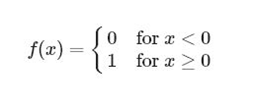

- 이 함수로 들어온 입력이 특정 임계점을 넘으면 1, 그렇지 않으면 0을 출력

In [2]:
def binary_step(x, threshold=0):
    return 0 if x < threshold else 1

In [19]:
def plot_and_visulize(image_url, function, derivative=False):
    X = [-10 + x/100 for x in range(2000)]
    y = [function(y) for y in X]
    
    plt.figure(figsize=(12,12))
    
    # 함수 그래프
    plt.subplot(3,2,1)
    plt.title('function')
    plt.plot(X,y)
    
    # 함수의 미분 그래프
    plt.subplot(3,2,2)
    plt.title('derivative')
    if derivative:
        dev_y = [derivative(y) for y in X]
        plt.plot(X,dev_y)
    
    # 무작위 샘플들 분포
    samples = np.random.rand(1000)
    samples -= np.mean(samples)
    plt.subplot(3,2,3)
    plt.title('samples')
    plt.hist(samples,100)
    
    # 활성화 함수를 통과한 샘플들 분포
    act_values = [function(y) for y in samples]
    plt.subplot(3,2,4)
    plt.title('activation values')
    plt.hist(act_values,100)
    
    # 원본 이미지
    image = np.array(Image.open(image_url), dtype=np.float64)[:,:,0]/255. # 구분을 위해 gray-scale해서 확인
    image -= np.median(image)
    plt.subplot(3,2,5)
    plt.title('origin image')
    plt.imshow(image, cmap='gray')
    
    # 활성화 함수를 통과한 이미지
    activation_image = np.zeros(image.shape)
    h, w = image.shape
    for i in range(w):
        for j in range(h):
            activation_image[j][i] += function(image[j][i])
    plt.subplot(3,2,6)
    plt.title('activation results')
    plt.imshow(activation_image, cmap='gray')
    
    return plt

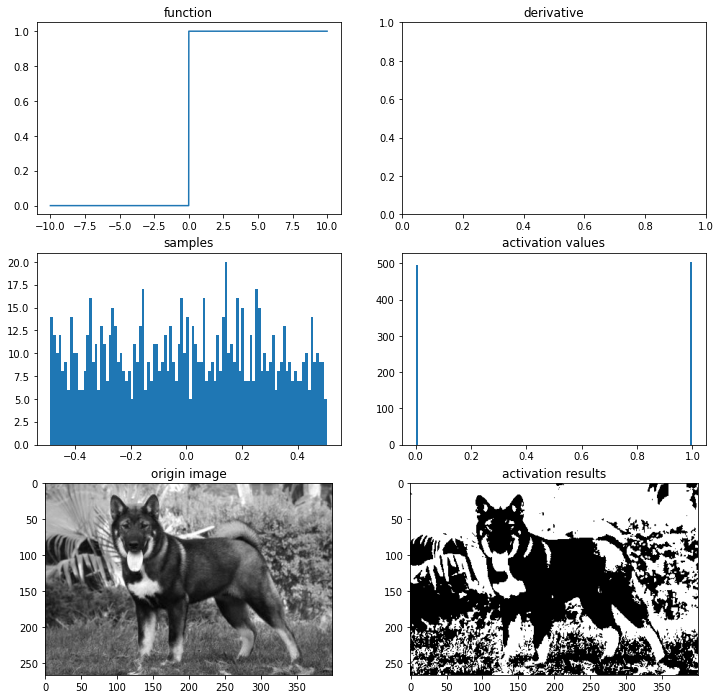

In [20]:
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'
ax = plot_and_visulize(img_path, binary_step)
ax.show()

이진 계단 함수는 초기의 신경망인 단층 퍼셉트론에서 자주 사용되었다. AND, OR 게이트에서는 단층 퍼셉트론 모델의 accuracy 가 1.0을 기록하면서 충분히 구현해 낼 수 있었지만, XOR 게이트를 구현할 수는 없었다. 단 층을 쌓아서 해결할 수 있었다.

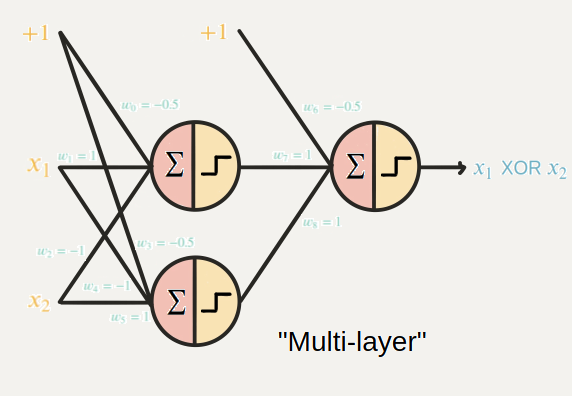

하지만 이진 계단 함수는 미분을 하면 무조건 0이 되므로 backpropagation을 할 수 없다는 문제점이 있다.

#### 2. 선형 활성화 함수

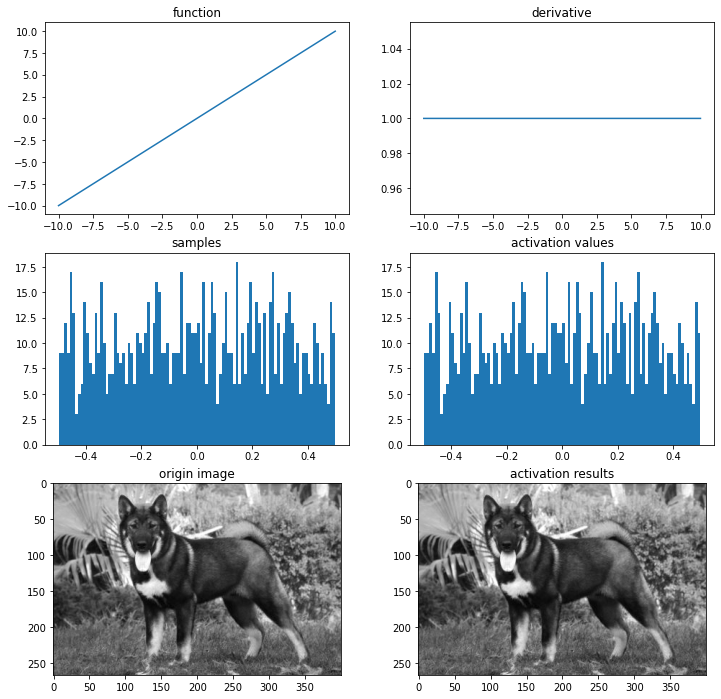

In [22]:
def linear(x):
    return x

def dev_linear(x):
    return 1

# 시각화
ax = plot_and_visulize(img_path, linear, dev_linear)
ax.show()

선형 함수는 층을 쌓아도 결국 하나의 노드를 쓰는 것과 같다. 즉, XOR 게이트를 해결할 수 없다는 것이다.

#### 3. 비선형 활성화 함수

1. sigmoid (logistic)

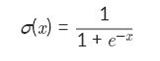

- 시그모이드 함수를 쓰는 주된 이유는 바로 치역이 0과 1 사이여서이다. 확률을 예측하는 모델에서 자주 사용된다.

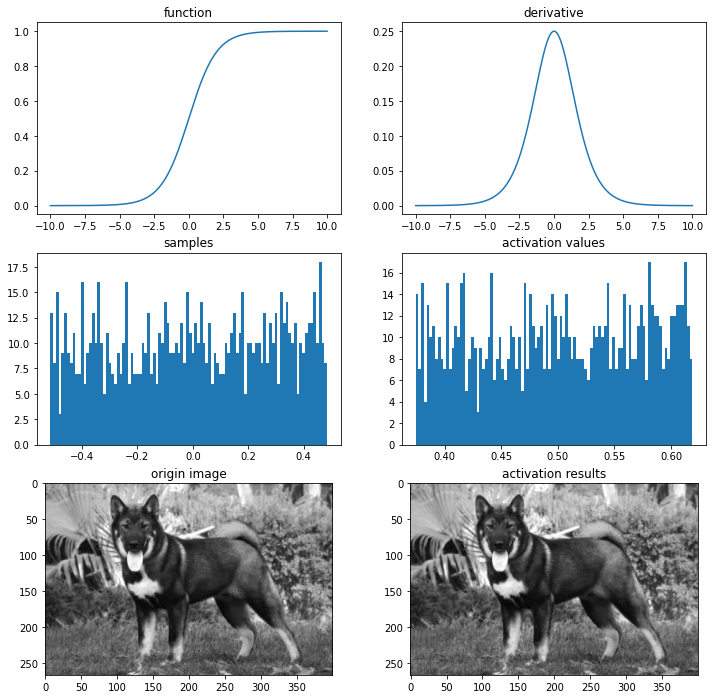

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x).astype(np.float64))

def dev_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

# 시각화
ax = plot_and_visulize(img_path, sigmoid, dev_sigmoid)
ax.show()

Sigmoid의 단점은 0 또는 1에서 포화(saturate)된다는 것이다. 입력값이 아무리 커져도, 작아져도 1과 0에 가까워져갈 뿐이다. 이 말은 역전파에서 gradient가 0에 가까워지므로 backpropagation을 해도 Weight update가 일어나지 않는다는 것이다.   
   
   
또한 Sigmoid는 zero-centered가 아니다. 여기서 발생하는 문제는 훈련의 시간이 오래걸리게 된다는 것이다. upstream gradient의 부호에 따라 이 노드의 가중치는 모두 양의 방향 혹은 음의 방향으로 업데이트 되므로, 이런 식으로 업데이트가 이루어지면 최적값을 향해 직선적으로 업데이트되는 것보다 훨씬 시간이 오래 걸리게 된다.

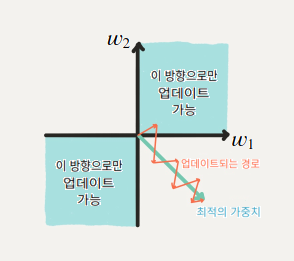

Sigmoid는 0과 1 사이의 출력값을 가지고 있기 때문에 이진 분류 문제에 많이 쓰인다.

2. Softmax   
Softmax는 클래스의 수 제한 없이 각 클래스의 확률을 구할 때 쓰인다.

3. tanh   
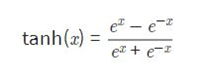

tanh는 sigmoid와 다르게 zero-centered 이다. 따라서 sigmoid함수를 사용한 모델보다 더 빨리 훈련된다.   
tanh 함수는 아래 그림에서 볼 수 있듯 -1 또는 1에서 포화된다.

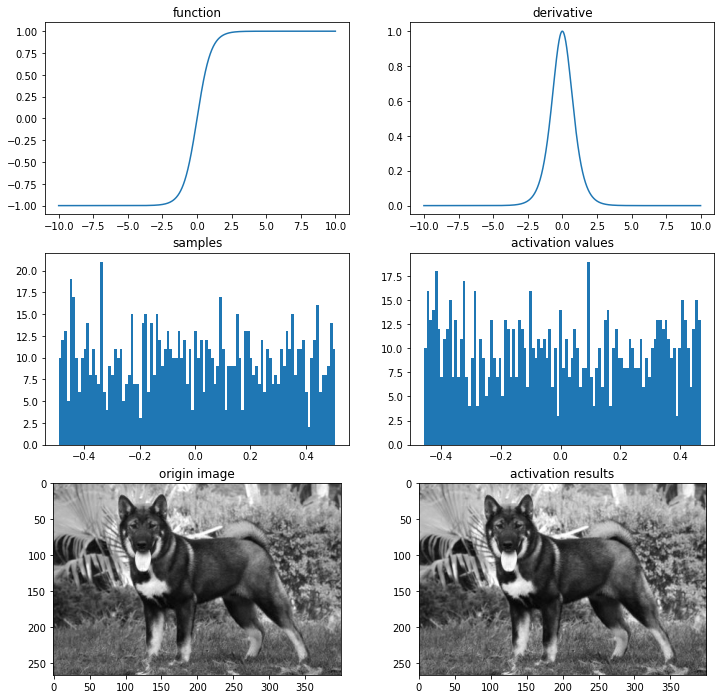

In [24]:
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def dev_tanh(x):
    return 1-tanh(x)**2

# 시각화
ax = plot_and_visulize(img_path, tanh, dev_tanh)
ax.show()

4. ReLU   

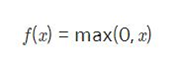

ReLU는 최근 가장 많이 사용되고 있는 활성화 함수이다.

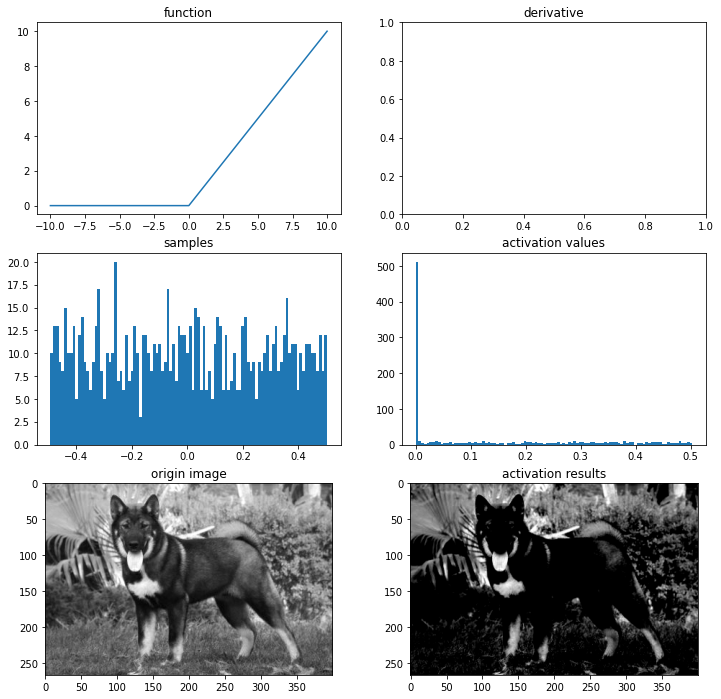

In [25]:
def relu(x):
    return max(0,x)

# 시각화
ax = plot_and_visulize(img_path, relu)
ax.show()

ReLU는 최소 0에서 무한대까지가 치역이다. ReLU를 사용한 모델은 tanh를 사용한 모델보다 몇 배는 더 빠르게 훈련이 된다.

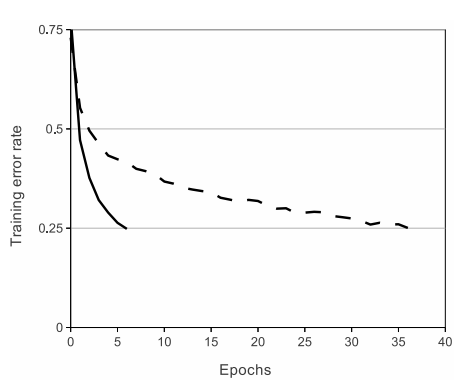

##### 근데 ReLU 함수를 사용한 모델은 비선형적 데이터의 특징을 잘 잡아내는가?

ReLU, 함수로 비선형 함수를 표현할 수 있는가? Sigmoid 처럼 곡선이 포함되어있지 않은데 어떻게 비선형적인 특징을 잡아낼까? 정답은 '가능하다' 이다. 

ReLU도 단점이 있다. 우선 출력값이 zero centered가 아니므로 위에서 언급했던 문제가 발생할 수 있다. 또한, 만약 이전 훈련 스텝에서 해당 노드의 가중치가 업데이트 되어 W값에 의해 입력값 x에 상관없이 0 이하로 나오게 되었다면, 이 이후의 업데이트에서는 gradient가 항상 0이 되어 가중치 업데이트가 일어나지 않게 된다. 즉, 노드가 죽어버리는 것이다. 이 문제는 특히 learning rate가 클 때 자주 발생한다.

##### ReLU의 단점을 극복하기 위한 시도들

- Leaky ReLU

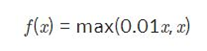

0을 출력하던 부분을 아주 작은 음수값을 출력하게 만들어주는 것이다.

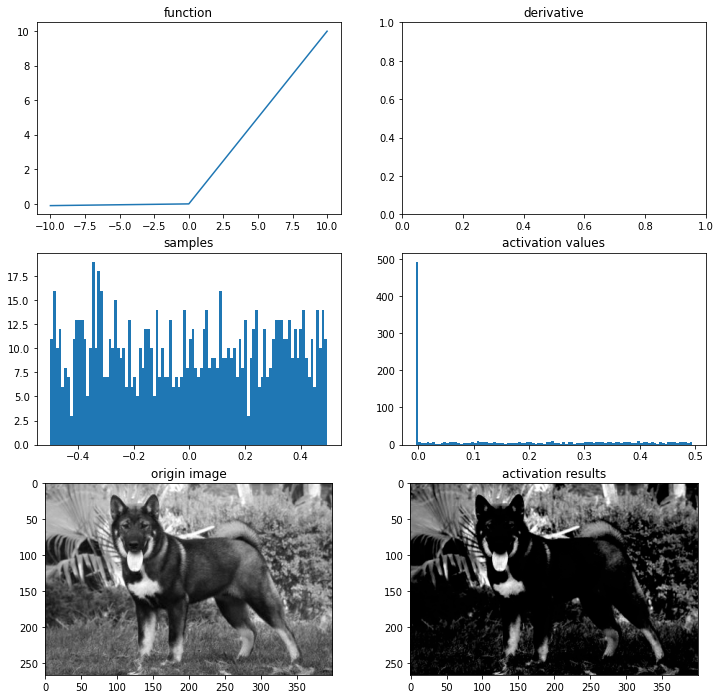

In [26]:
def leaky_relu(x):
    return max(0.01*x,x)

# 시각화
ax = plot_and_visulize(img_path, leaky_relu)
ax.show()

- PReLU

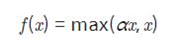

Leaky ReLU와 유사하지만 새로운 파라미터를 추가하여 0 미만일 때의 gradient가 훈련되게 하였다.

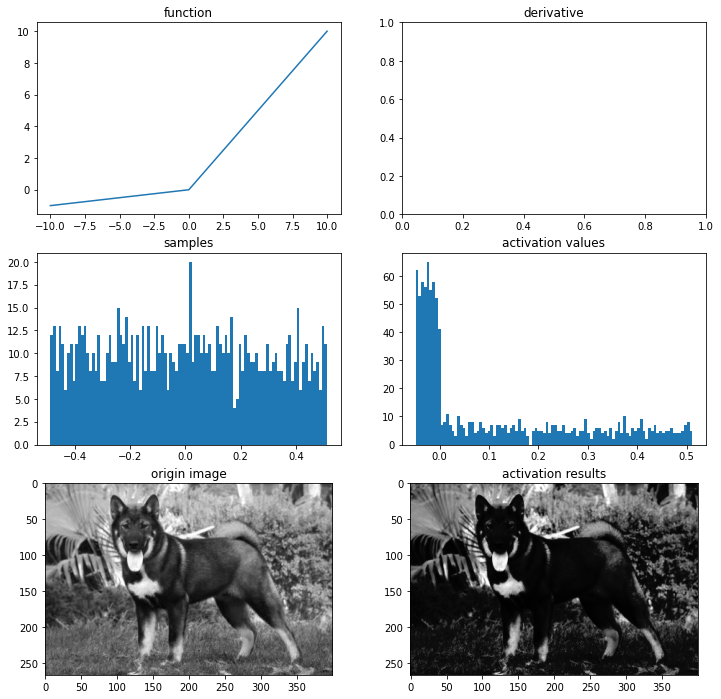

In [27]:
def prelu(x, alpha):
    return max(alpha*x,x)

# 시각화
ax = plot_and_visulize(img_path, lambda x: prelu(x, 0.1)) # parameter alpha=0.1일 때

ax.show()

- ELU

ReLU의 모든 장점인 zero-centered가 아닌 것, dying ReLU 문제 모두를 해결한 활성화 함수이다.

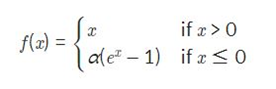

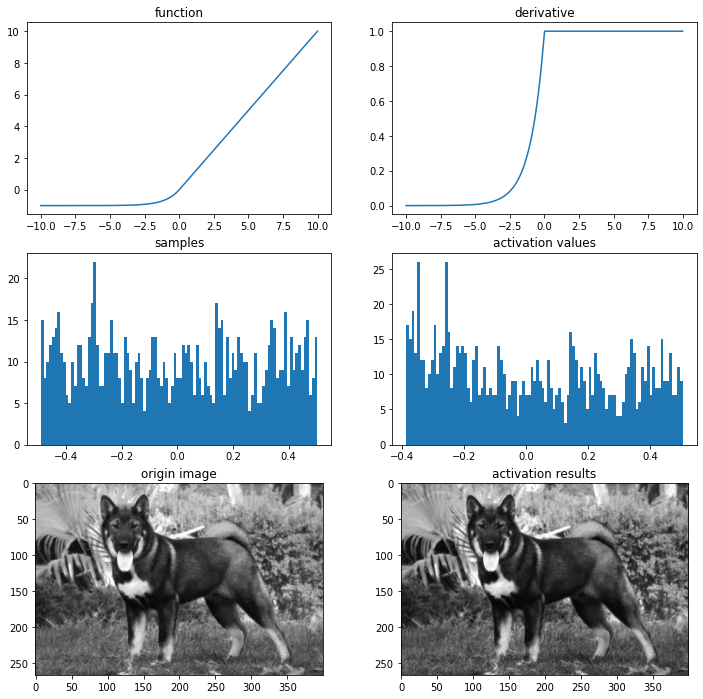

In [28]:
def elu(x, alpha):
    return x if x > 0 else alpha*(np.exp(x)-1)

def dev_elu(x, alpha):
    return 1 if x > 0 else elu(x, alpha) + alpha

# 시각화
ax = plot_and_visulize(img_path, lambda x: elu(x, 1), lambda x: dev_elu(x, 1)) # alpha가 1일 때
ax.show()

하지만 이 함수는 exponential 연산이 들어가서 계산 비용이 높다.